In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier ,RandomForestClassifier ,GradientBoostingClassifier
from xgboost import XGBClassifier 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge,Lasso
from sklearn.metrics import roc_auc_score ,mean_squared_error,accuracy_score,classification_report,roc_curve,confusion_matrix
import warnings
warnings.filterwarnings('ignore')
from scipy.stats.mstats import winsorize
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler 
  

In [3]:
# Load the dataframe
df=pd.read_csv('data/train.csv',sep=',')

In [4]:
# Seperate the features and target
target = df.iloc[:,5]
predictors = df.drop(['Claim'],axis=1)

In [5]:
# Function to identify numeric features
def numeric_features(dataset):
    numeric_col = dataset.select_dtypes(include=['number']).columns
    return numeric_col

numeric_columns = numeric_features(predictors)
print("Numeric Features:")
print(numeric_columns)

Numeric Features:
Index(['ID', 'Duration', 'Net Sales', 'Commision (in value)', 'Age'], dtype='object')


In [6]:
# Function to identify categorical features
def categorical_features(dataset):
    categorical_col = dataset.select_dtypes(exclude=['number']).columns
    return categorical_col

categorical_columns = categorical_features(predictors)
print("Categorical Features:")
print(categorical_columns)

Categorical Features:
Index(['Agency', 'Agency Type', 'Distribution Channel', 'Product Name',
       'Destination', 'Gender'],
      dtype='object')


In [7]:
def class_imbalance(target):
    class_values = (target.value_counts()/target.value_counts().sum())*100
    return class_values

class_imbalance(target)
#data is highly imbalanced since 98% is no

0    98.534212
1     1.465788
Name: Claim, dtype: float64

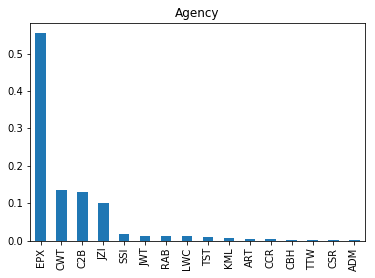

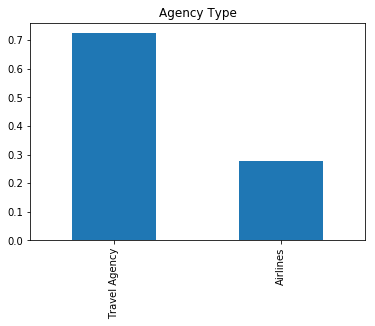

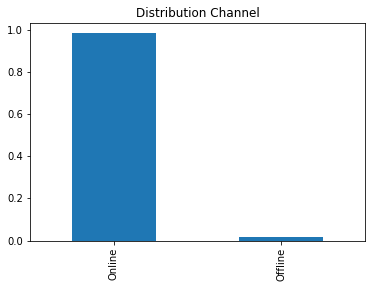

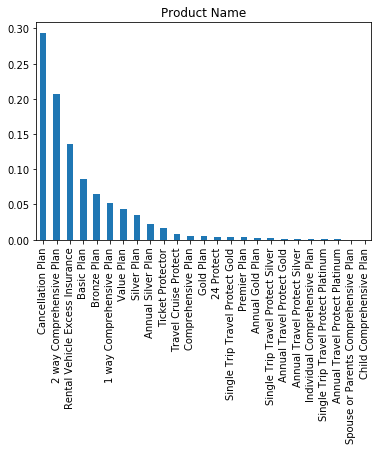

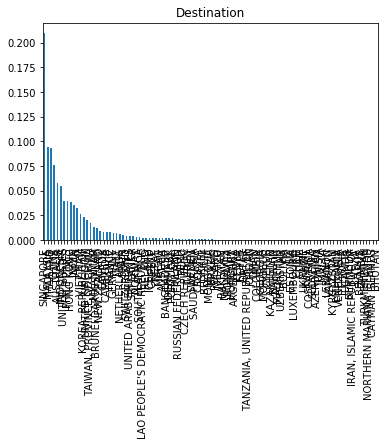

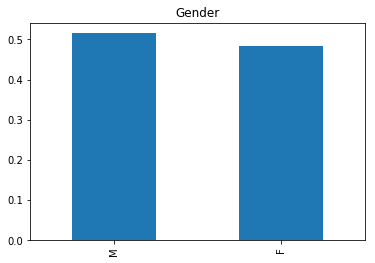

In [8]:
# Function to perform univariate analysis of categorical columns
def plot_categorical_columns(dataframe):
    categorical_columns = categorical_features(dataframe)
    dataframe = dataframe[categorical_columns]
    for i in dataframe:
        plt.title(i)
        dataframe[i].value_counts(normalize=True).plot(kind='bar')
        plt.show()

plot = plot_categorical_columns(predictors)

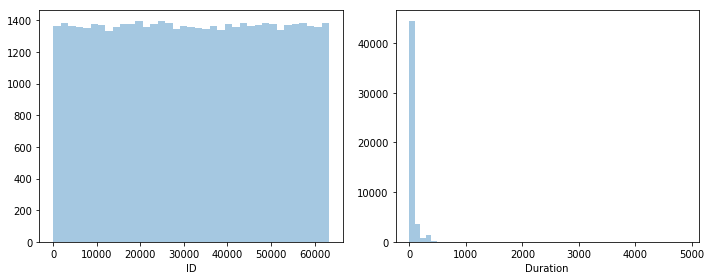

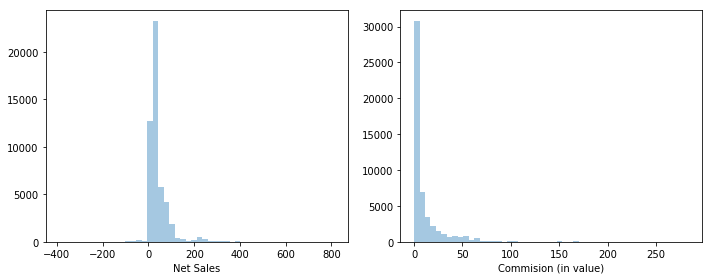

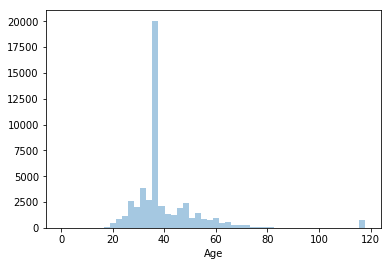

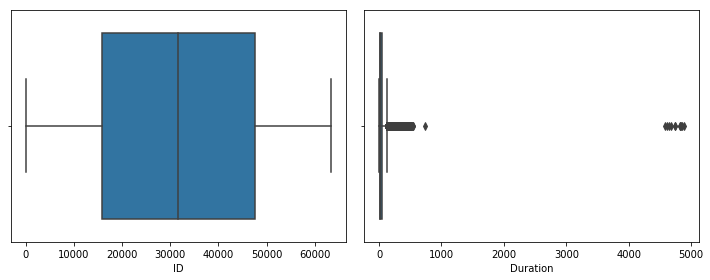

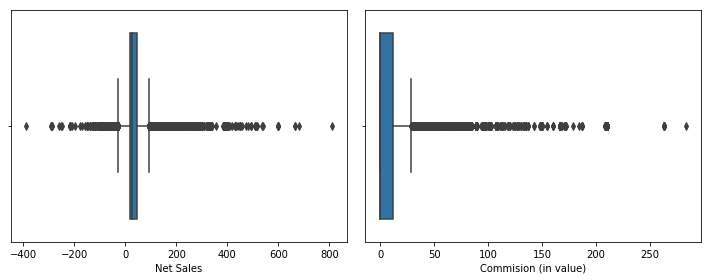

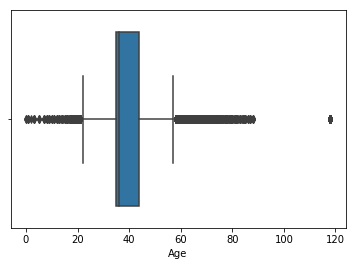

In [9]:
# Code Starts here

# Function to plot histograms
def plot_continuous_columns(dataframe):
    numeric_columns = numeric_features(dataframe)
    dataframe = dataframe[numeric_columns]
    
    for i in range(0,len(numeric_columns),2):
        if len(numeric_columns) > i+1:
            plt.figure(figsize=(10,4))
            plt.subplot(121)
            sns.distplot(dataframe[numeric_columns[i]], kde=False)
            plt.subplot(122)            
            sns.distplot(dataframe[numeric_columns[i+1]], kde=False)
            plt.tight_layout()
            plt.show()

        else:
            sns.distplot(dataframe[numeric_columns[i]], kde=False)

# Function to plot boxplots
def plot_box_plots(dataframe):
    numeric_columns = numeric_features(dataframe)
    dataframe = dataframe[numeric_columns]
    
    for i in range(0,len(numeric_columns),2):
        if len(numeric_columns) > i+1:
            plt.figure(figsize=(10,4))
            plt.subplot(121)
            sns.boxplot(dataframe[numeric_columns[i]])
            plt.subplot(122)            
            sns.boxplot(dataframe[numeric_columns[i+1]])
            plt.tight_layout()
            plt.show()

        else:
            sns.boxplot(dataframe[numeric_columns[i]])

plot_continuous_columns(predictors)            
plot_box_plots(predictors)

# Code ends here

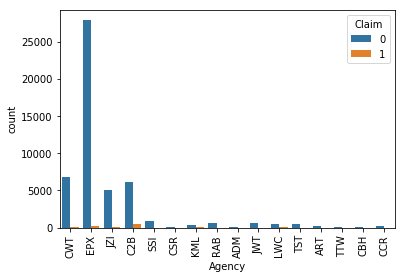

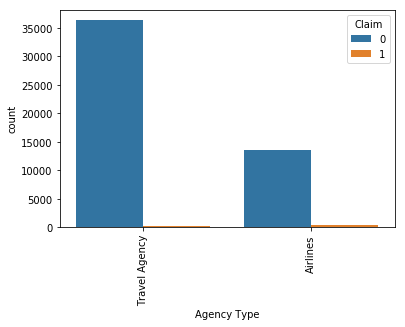

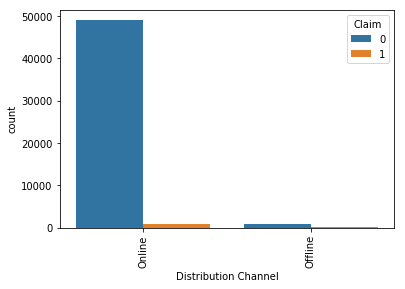

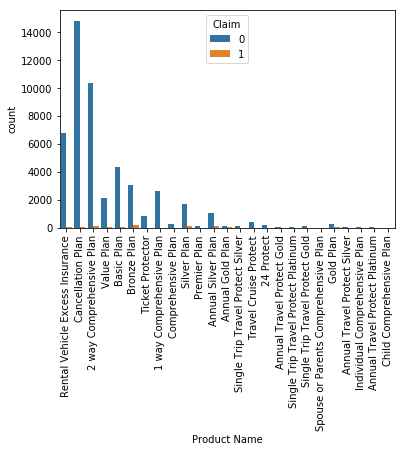

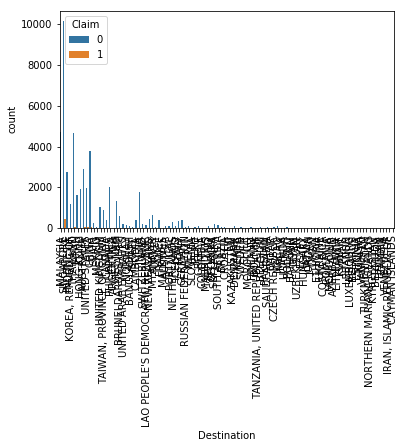

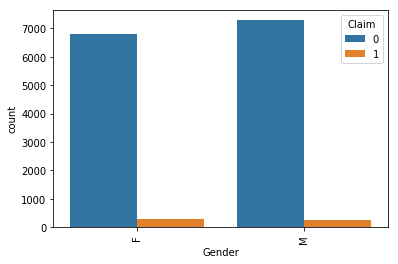

In [10]:
def bivariate_analysis_categorical(dataframe,target):
    cols = list(dataframe)
    for col in cols:
        if col in dataframe.select_dtypes(exclude=np.number).columns:
            sns.countplot(x=dataframe[col],hue=target,data=dataframe)
            plt.xticks(rotation='vertical')
            plt.show()

bivariate_analysis_categorical(predictors,target)

In [10]:
predictors.drop(columns=['ID','Gender'],inplace=True)
#predictors.head()

In [11]:
predictors.skew()

Duration                22.872743
Net Sales                3.328243
Commision (in value)     4.078189
Age                      2.978478
dtype: float64

In [ ]:
#highly skewed

In [12]:
# Code starts here

# Function to detect outliers in every feature
def detect_outliers(dataframe):
    cols = list(dataframe)
    
    for column in cols:
        if column in dataframe.select_dtypes(include=np.number).columns:
            q1 = dataframe[column].quantile(0.25)
            q3 = dataframe[column].quantile(0.75)
            iqr = q3 - q1
            fence_low = q1 - (1.5*iqr)
            fence_high = q3 + (1.5*iqr)

            print(column + ' ---------', dataframe.loc[(dataframe[column] < fence_low) | (dataframe[column] > fence_high)].shape[0])

detect_outliers(predictors)


# Code ends here

Duration --------- 4465
Net Sales --------- 4444
Commision (in value) --------- 5629
Age --------- 4702


In [13]:
# Function to treat outliers 
def treat_outliers(dataframe):
    cols = list(dataframe)
    for col in cols:
        if col in dataframe.select_dtypes(include=np.number).columns:
            dataframe[col] = winsorize(dataframe[col], limits=[0.05, 0.1],inclusive=(True, True))
    
    return dataframe    


predictors = treat_outliers(predictors)
print(detect_outliers(predictors))

Duration --------- 0
Net Sales --------- 0
Commision (in value) --------- 5629
Age --------- 0
None


In [15]:
import scipy.stats as scs

In [16]:
features = []
skewness = []
for i in predictors.select_dtypes(include=np.number).columns:
    features.append(i)
    skewness.append(scs.skew(predictors[i]))
skewed = pd.DataFrame({'Features':features,'Skewness':skewness})
print(skewed)

               Features  Skewness
0              Duration  1.068525
1             Net Sales  0.857217
2  Commision (in value)  1.283735
3                   Age  0.650163


In [17]:
# If skewness is greater than 1 the feature is highly positively skewed
positively_skewed_variables = skewed[(skewed['Skewness']>1)]

# If the skewness is less than -1 the feature is highly negatively skewed.
negatively_skewed_variables = skewed[(skewed['Skewness']<-1)]


print('Positively Skewed Features \n',positively_skewed_variables)
print('*'*50)
print('Negatively Skewed Features \n',negatively_skewed_variables) 

Positively Skewed Features 
                Features  Skewness
0              Duration  1.068525
2  Commision (in value)  1.283735
**************************************************
Negatively Skewed Features 
 Empty DataFrame
Columns: [Features, Skewness]
Index: []


In [18]:
# Let's remove the skewness in the positively skewed variables by using a log transform
for i in positively_skewed_variables['Features']:
    predictors[i] = np.log1p(predictors[i])

In [19]:
features = []
skewness = []
for i in predictors.select_dtypes(include=np.number).columns:
    features.append(i)
    skewness.append(scs.skew(predictors[i]))
skewed = pd.DataFrame({'Features':features,'Skewness':skewness})
print(skewed)

               Features  Skewness
0              Duration -0.056167
1             Net Sales  0.857217
2  Commision (in value)  0.504236
3                   Age  0.650163


In [20]:
# Code Starts here

le = LabelEncoder()
# Function that auto encodes any dataframe column of type category or object.
def dummyEncode(dataset):
        
        columnsToEncode = list(dataset.select_dtypes(include=['category','object']))
        le = LabelEncoder()
        for feature in columnsToEncode:
            try:
                dataset[feature] = le.fit_transform(dataset[feature])
            except:
                print('Error encoding '+feature)
        return dataset
predictors = dummyEncode(predictors)
target = pd.DataFrame(le.fit_transform(target))


# Code ends here

In [23]:
scaler = StandardScaler() 
  
# To scale data 
scaler.fit(predictors) 

StandardScaler(copy=True, with_mean=True, with_std=True)

Highly Correlated Variables


Series([], dtype: float64)

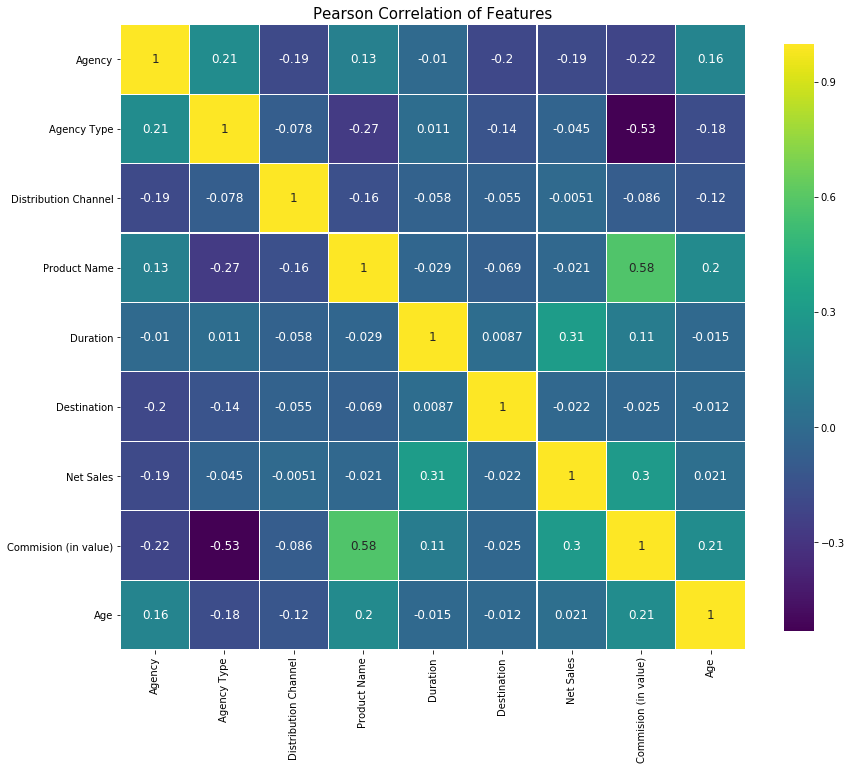

In [24]:
# Code Starts here

#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = 'viridis',
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)
    
    correlation = df.corr().unstack().sort_values(kind='quicksort')
    print('Highly Correlated Variables')
    return correlation[((correlation>=0.75) | (correlation<=-0.75)) & (correlation!=1)]

correlation_heatmap(predictors)

# Code Ends Here

In [25]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(predictors,target, test_size=0.3, random_state=5)


In [26]:
global X_test,Y_test

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6969
           1       0.00      0.00      0.00       109

    accuracy                           0.98      7078
   macro avg       0.49      0.50      0.50      7078
weighted avg       0.97      0.98      0.98      7078

ROC_AUC_SCORE is 0.5


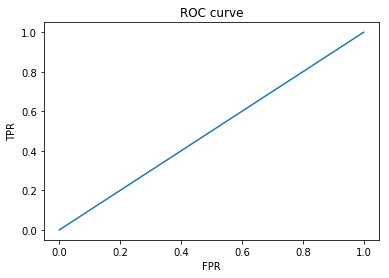

AUC Score = 50.00 %
On Model - 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6969
           1       0.06      0.06      0.06       109

    accuracy                           0.97      7078
   macro avg       0.52      0.52      0.52      7078
weighted avg       0.97      0.97      0.97      7078

ROC_AUC_SCORE is 0.5204200515783529


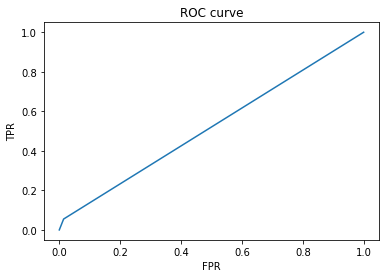

AUC Score = 52.04 %
On Model - 
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6969
           1       0.06      0.01      0.02       109

    accuracy                           0.98      7078
   macro avg       0.52      0.50      0.50      7078
weighted avg       0.97      0.98      0.98      7078

ROC_AUC_SCORE is 0.5035109613873234


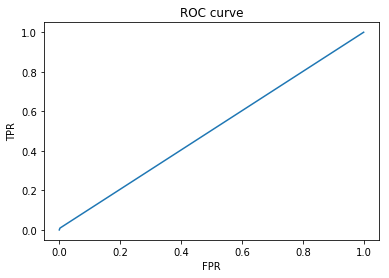

AUC Score = 50.35 %
On Model - 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6969
           1       0.00      0.00      0.00       109

    accuracy                           0.98      7078
   macro avg       0.49      0.50      0.50      7078
weighted avg       0.97      0.98      0.98      7078

ROC_AUC_SCORE is 0.5


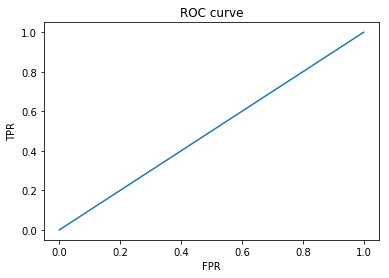

AUC Score = 50.00 %
On Model - 
GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6969
           1       0.00      0.00      0.00       109

    accuracy                           0.98      7078
   macro avg       0.49      0.50      0.50      7078
weighted avg       0

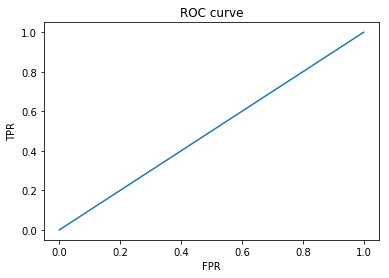

AUC Score = 50.00 %
On Model - 
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [170]:
def run_model(predictor_train,target_train, model):
    '''
    Performs model training and tests using ROC-AUC 
    returns AUC score
    '''
    x_train,x_val,y_train,y_val = train_test_split(predictor_train,target_train,test_size=0.2,random_state=42)
    model.fit(x_train, y_train)
    y_scores = model.predict(x_val)
    auc = roc_auc_score(y_val, y_scores)
    print(classification_report(y_val,y_scores))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_scores)
    print('ROC_AUC_SCORE is',roc_auc_score(y_val, y_scores))
    
    #fpr, tpr, _ = roc_curve(y_test, predictions[:,1])
    
    plt.plot(false_positive_rate, true_positive_rate)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()
    return auc

models = [LogisticRegression,DecisionTreeClassifier, RandomForestClassifier,GradientBoostingClassifier,XGBClassifier]
for model in models:
    # run model
    model = model()
    auc = run_model(X_train, Y_train, model) # train and returns AUC test score
    print('AUC Score = %.2f' %(auc*100) +' %\nOn Model - \n'+str(model))
    print('===='*20)

In [32]:
# Code Starts here

def feature_selection(dataframe,target,number_of_features,model):
    X = dataframe
    y = target

    models = model()
    rfe = RFE(models,number_of_features)
    rfe = rfe.fit(X,y)
    print('Features  to be selected for {}'.format(str(models)))
    features = pd.Series(rfe.ranking_, index=X.columns)
    print(features[features.values==1].index.tolist())
    print('===='*30)

# Choosing the models
models = [LogisticRegression,DecisionTreeClassifier,RandomForestClassifier,XGBClassifier]

# Selecting 8 number of features
for i in models:
    feature_selection(X_train,Y_train,8,i)
    
# Code ends here

Features  to be selected for LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
['Agency', 'Agency Type', 'Distribution Channel', 'Product Name', 'Duration', 'Net Sales', 'Commision (in value)', 'Age']
Features  to be selected for DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
['Agency', 'Agency Type', 'Product Name', 'Duration', 'Destination', 'Net Sales', 'Commisi

In [28]:
def grid_search_random_forrest(dataframe,target):
    X = dataframe
    y = target
    

    x_train,x_val,y_train,y_val = train_test_split(X,y, test_size=0.3, random_state=42, stratify=y)
    rfc = RandomForestClassifier()
    param_grid = { 
#     'n_estimators': [11],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
    }
    grid_search_model = GridSearchCV(rfc, param_grid=param_grid)
    grid_search_model.fit(x_train, y_train)
    
    return grid_search_model.best_params_

print('Best Parameters are:')
grid_search_random_forrest(X_train,Y_train)

Best Parameters are:


{'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto'}

On Validation data
ROC_AUC_SCORE is 0.7278151816377756
              precision    recall  f1-score   support

           0       0.99      0.87      0.93     10448
           1       0.07      0.59      0.12       169

    accuracy                           0.87     10617
   macro avg       0.53      0.73      0.52     10617
weighted avg       0.98      0.87      0.91     10617



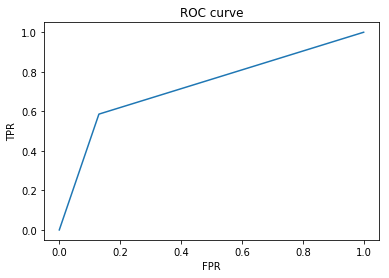

On Test data
ROC_AUC_SCORE is 0.7373375836843049
              precision    recall  f1-score   support

           0       0.99      0.88      0.93     14954
           1       0.06      0.60      0.12       212

    accuracy                           0.87     15166
   macro avg       0.53      0.74      0.52     15166
weighted avg       0.98      0.87      0.92     15166



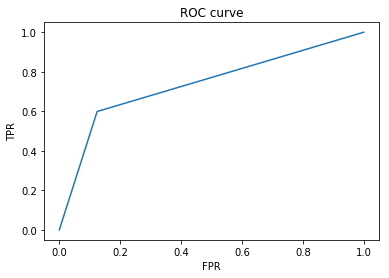

In [29]:
from sklearn.metrics import roc_auc_score,roc_curve,classification_report
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
def grid_search_random_forrest_best(dataframe,target):
   X = dataframe
   y = target
   x_train,x_val,y_train,y_val = train_test_split(X, y, test_size=0.3, random_state=42)
   # Applying Smote for dealing with class imbalance
   smote = SMOTE(kind='regular')
   X_sm, y_sm =  smote.fit_sample(x_train, y_train)
   rfc = RandomForestClassifier(n_estimators=11, max_features='auto', max_depth=4, criterion='gini')
   rfc.fit(X_sm, y_sm)
   y_pred = rfc.predict(x_val)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_pred)
   print('On Validation data')
   print('ROC_AUC_SCORE is',roc_auc_score(y_val, y_pred))
   print(classification_report(y_val, y_pred))
   #fpr, tpr, _ = roc_curve(y_test, predictions[:,1])
   plt.clf()
   plt.plot(false_positive_rate, true_positive_rate)
   plt.xlabel('FPR')
   plt.ylabel('TPR')
   plt.title('ROC curve')
   plt.show()
   print('On Test data')
   y_pred = rfc.predict(X_test[['Agency', 'Agency Type', 'Product Name', 'Duration', 'Destination', 'Net Sales', 'Commision (in value)', 'Age']])
   false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, y_pred)
   print('ROC_AUC_SCORE is',roc_auc_score(Y_test, y_pred))
   print(classification_report(Y_test, y_pred))
   #fpr, tpr, _ = roc_curve(y_test, predictions[:,1])
   plt.clf()
   plt.plot(false_positive_rate, true_positive_rate)
   plt.xlabel('FPR')
   plt.ylabel('TPR')
   plt.title('ROC curve')
   plt.show()
   return rfc
rfc_features =['Agency', 'Agency Type', 'Product Name', 'Duration', 'Destination', 'Net Sales', 'Commision (in value)', 'Age']
# Applying the best paramaters on the best features obtained using RFE
rfc=grid_search_random_forrest_best(X_train[rfc_features],Y_train)






On Validation Data
Accuracy is  0.886220212866158
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     10448
           1       0.08      0.56      0.14       169

    accuracy                           0.89     10617
   macro avg       0.53      0.73      0.54     10617
weighted avg       0.98      0.89      0.93     10617

ROC_AUC_SCORE is  0.7267963291861866
[[9314 1134]
 [  74   95]]


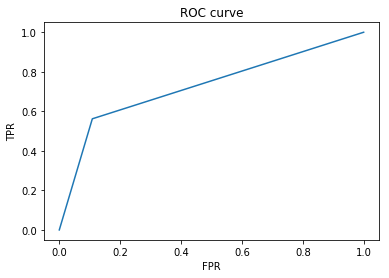

On Test Data
Accuracy is  0.8892259000395621
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     14954
           1       0.07      0.54      0.12       212

    accuracy                           0.89     15166
   macro avg       0.53      0.72      0.53     15166
weighted avg       0.98      0.89      0.93     15166

ROC_AUC_SCORE is  0.7182974328822224
[[13371  1583]
 [   97   115]]


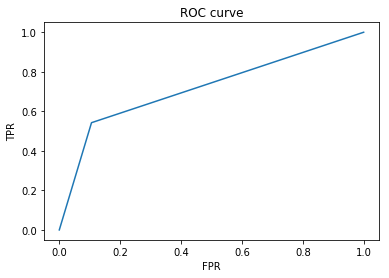

In [122]:
def xgboost(dataframe,target):
   X = dataframe
   y = target
   x_train,x_val,y_train,y_val = train_test_split(X, y, test_size=0.3, random_state=42)
   # Applying Smote for dealing with class imbalance
   smote = SMOTE(kind='regular')
   X_sm, y_sm =  smote.fit_sample(x_train, y_train)
   model = XGBClassifier(n_estimators=50, max_depth=4)
   model.fit(pd.DataFrame(X_sm,columns=X_test.columns), y_sm)
   y_pred = model.predict(x_val)
   print('On Validation Data')
   print('Accuracy is ',model.score(x_val, y_val))
   print(classification_report(y_val, y_pred))
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_pred)
   #     print(auc(false_positive_rate, true_positive_rate))
   print('ROC_AUC_SCORE is ', roc_auc_score(y_val, y_pred))
   plt.clf()
   plt.plot(false_positive_rate, true_positive_rate)
   print(confusion_matrix(y_val,y_pred))
   plt.xlabel('FPR')
   plt.ylabel('TPR')
   plt.title('ROC curve')
   plt.show()
   print('On Test Data')
   y_pred = model.predict(X_test)
   print('Accuracy is ',model.score(X_test, Y_test))
   print(classification_report(Y_test, y_pred))
   false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, y_pred)
#     print(auc(false_positive_rate, true_positive_rate))
   print('ROC_AUC_SCORE is ', roc_auc_score(Y_test, y_pred))
   plt.clf()
   plt.plot(false_positive_rate, true_positive_rate)
   print(confusion_matrix(Y_test,y_pred))
   plt.xlabel('FPR')
   plt.ylabel('TPR')
   plt.title('ROC curve')
   plt.show()  
   return model

features =['Agency', 'Agency Type', 'Distribution Channel', 'Product Name', 'Duration', 'Destination', 'Net Sales', 'Commision (in value)', 'Age']
xgb_model =xgboost(X_train[features],Y_train)


In [202]:
#xgb_model.predict()

In [136]:
# Load the dataframe
df_test=pd.read_csv('data/test.csv',sep=',')

In [137]:
df_test = df_test[features]

In [138]:
df_test = dummyEncode(df_test[features])

In [139]:
#y_scores = xgb_model.predict(df_test[features])
y_scores = xgb_model.predict(df_test)

In [140]:
y_scores = np.array(y_scores)

In [141]:
unique_values,occur_count = np.unique(y_scores,return_counts=True)

In [145]:
unique_values,occur_count

(array([0, 1], dtype=int64), array([11363,  1298], dtype=int64))

In [147]:
# Load the dataframe
df9=pd.read_csv('data/test.csv',sep=',')
df_sample = pd.DataFrame(df9.iloc[:,0])
df_sample['Claim']=y_scores.tolist()

In [148]:
df_sample.head()

,ID,Claim
0,25902,0
1,19535,0
2,43717,0
3,48271,0
4,52318,0


In [154]:
df_sample[df_sample['Claim']==1].head()

,ID,Claim
5,31820,1
17,33032,1
32,2363,1
33,26520,1
36,55190,1


In [158]:
df_sample.to_csv('Submission2.csv') 


In [159]:
features

['Agency',
 'Agency Type',
 'Distribution Channel',
 'Product Name',
 'Duration',
 'Destination',
 'Net Sales',
 'Commision (in value)',
 'Age']

In [160]:
y_scores_1 = rfc.predict(df_test[rfc_features])

In [162]:
y_scores_1 = np.array(y_scores_1)

In [165]:
unique_values,occur_count = np.unique(y_scores_1,return_counts=True)

In [166]:
unique_values,occur_count

(array([0, 1], dtype=int64), array([10960,  1701], dtype=int64))

In [167]:
# Load the dataframe
df_sample_rfc = pd.DataFrame(df9.iloc[:,0])
df_sample_rfc['Claim']=y_scores_1.tolist()

In [168]:
df_sample_rfc[df_sample_rfc['Claim']==1]

,ID,Claim
5,31820,1
17,33032,1
32,2363,1
33,26520,1
36,55190,1
38,43859,1
60,44259,1
84,36390,1
101,47416,1
111,21179,1


In [218]:
sample = pd.DataFrame(df9)
sample['Claim'] =y_scores_1.tolist()
sample.head()
sample2 = sample[sample['Claim']==1]
sample2

,ID,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Gender,Age,Claim
5,31820,C2B,Airlines,Online,Silver Plan,18,SINGAPORE,63.50,15.88,F,52,1
17,33032,C2B,Airlines,Online,Bronze Plan,15,SINGAPORE,34.50,8.63,M,35,1
32,2363,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,252.85,63.21,M,61,1
33,26520,C2B,Airlines,Online,Silver Plan,3,SINGAPORE,24.05,6.01,M,57,1
36,55190,C2B,Airlines,Online,Annual Silver Plan,392,SINGAPORE,259.20,64.80,F,27,1
38,43859,C2B,Airlines,Online,Bronze Plan,15,SINGAPORE,16.00,4.00,F,29,1
60,44259,C2B,Airlines,Online,Annual Gold Plan,378,SINGAPORE,333.00,83.25,F,47,1
84,36390,TTW,Travel Agency,Offline,Child Comprehensive Plan,369,SINGAPORE,74.00,0.00,M,9,1
101,47416,C2B,Airlines,Online,Annual Gold Plan,370,SINGAPORE,333.00,83.25,M,33,1
111,21179,C2B,Airlines,Online,Annual Silver Plan,375,SINGAPORE,187.85,46.96,F,67,1


In [172]:
df_sample_rfc.to_csv('Submissionrfcfile.csv') 


On Validation Data
AUC_ROC_SCORE is  0.5631405348097537
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     10448
           1       0.08      0.15      0.11       169

    accuracy                           0.96     10617
   macro avg       0.53      0.56      0.54     10617
weighted avg       0.97      0.96      0.97     10617

[[10160   288]
 [  143    26]]


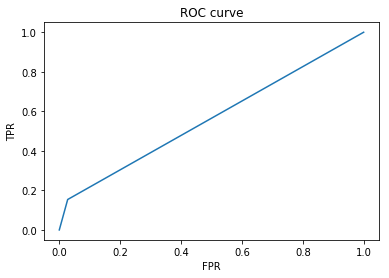

On Test Data
AUC_ROC_SCORE is  0.5459557107204231
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     14954
           1       0.06      0.12      0.08       212

    accuracy                           0.96     15166
   macro avg       0.52      0.55      0.53     15166
weighted avg       0.97      0.96      0.97     15166

[[14565   389]
 [  187    25]]


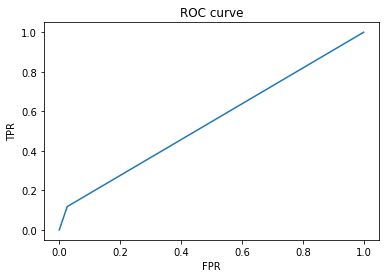

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators='warn',
                                                     n_jobs=None,
       

In [179]:
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier


def ensemble_func2(dataframe,target):
    X = dataframe
    y = target
    
    x_train,x_val,y_train,y_val = train_test_split(X, y, test_size=0.3, random_state=42)

    smote = SMOTE(kind='regular')
    X_sm, y_sm =  smote.fit_sample(x_train, y_train)
    
    model1 = RandomForestClassifier()
    
    model2 = DecisionTreeClassifier()
    
    model = VotingClassifier(estimators=[('rf', model1), ('xgb', model2)], voting='hard')
    model.fit(X_sm,y_sm)
    y_pred = model.predict(x_val)
    model.score(x_val,y_val)

        
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_pred)
    print('On Validation Data')
    print('AUC_ROC_SCORE is ',roc_auc_score(y_val, y_pred))
    
    print(classification_report(y_val, y_pred))
    print(confusion_matrix(y_val, y_pred))
    
    plt.clf()
    plt.plot(false_positive_rate, true_positive_rate)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()
    
    y_pred = model.predict(X_test)
    model.score(X_test,Y_test)
    
    print('On Test Data')    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, y_pred)

    print('AUC_ROC_SCORE is ',roc_auc_score(Y_test, y_pred))
    
    print(classification_report(Y_test, y_pred))
    print(confusion_matrix(Y_test, y_pred))
    
    plt.clf()
    plt.plot(false_positive_rate, true_positive_rate)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()
    
    return model
    
    
rfc_score_ensemble = ensemble_func2(X_train,Y_train)
rfc_score_ensemble

In [180]:
rfc_score_ensemble

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators='warn',
                                                     n_jobs=None,
       

In [181]:
#y_scores = xgb_model.predict(df_test[features])
y_scores_ensemble = rfc_score_ensemble.predict(df_test)
y_scores_ensemble = np.array(y_scores_ensemble)
unique_values,occur_count = np.unique(y_scores_ensemble,return_counts=True)
unique_values,occur_count


(array([0, 1], dtype=int64), array([12459,   202], dtype=int64))

In [182]:

df_sample_ensemble = pd.DataFrame(df9.iloc[:,0])
df_sample_ensemble['Claim']=y_scores.tolist()

In [183]:
df_sample_ensemble.to_csv('Submissionensemble.csv') 

On Validation data
ROC_AUC_SCORE is 0.7334367099504336
              precision    recall  f1-score   support

           0       0.99      0.86      0.92     10448
           1       0.07      0.60      0.12       169

    accuracy                           0.86     10617
   macro avg       0.53      0.73      0.52     10617
weighted avg       0.98      0.86      0.91     10617



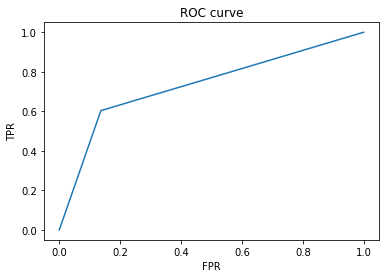

On Test data
ROC_AUC_SCORE is 0.7265841662860446
              precision    recall  f1-score   support

           0       0.99      0.87      0.93     14954
           1       0.06      0.58      0.11       212

    accuracy                           0.86     15166
   macro avg       0.53      0.73      0.52     15166
weighted avg       0.98      0.86      0.92     15166



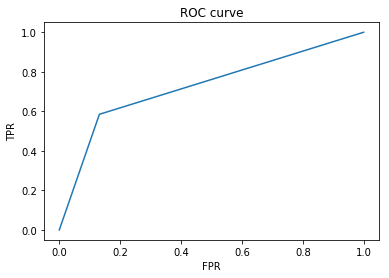

In [201]:
from sklearn.metrics import roc_auc_score,roc_curve,classification_report
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
def grid_search_random_forrest_best(dataframe,target):
   X = dataframe
   y = target
   x_train,x_val,y_train,y_val = train_test_split(X, y, test_size=0.3, random_state=42)
   # Applying Smote for dealing with class imbalance
   smote = SMOTE(kind='regular')
   X_sm, y_sm =  smote.fit_sample(x_train, y_train)
   rfc = RandomForestClassifier(n_estimators=11, max_features='auto', max_depth=4, criterion='gini',class_weight="balanced")
   rfc.fit(X_sm, y_sm)
   y_pred = rfc.predict(x_val)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_pred)
   print('On Validation data')
   print('ROC_AUC_SCORE is',roc_auc_score(y_val, y_pred))
   print(classification_report(y_val, y_pred))
   #fpr, tpr, _ = roc_curve(y_test, predictions[:,1])
   plt.clf()
   plt.plot(false_positive_rate, true_positive_rate)
   plt.xlabel('FPR')
   plt.ylabel('TPR')
   plt.title('ROC curve')
   plt.show()
   print('On Test data')
   y_pred = rfc.predict(X_test[['Agency', 'Agency Type', 'Product Name', 'Duration', 'Destination', 'Net Sales', 'Commision (in value)', 'Age']])
   false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, y_pred)
   print('ROC_AUC_SCORE is',roc_auc_score(Y_test, y_pred))
   print(classification_report(Y_test, y_pred))
   #fpr, tpr, _ = roc_curve(y_test, predictions[:,1])
   plt.clf()
   plt.plot(false_positive_rate, true_positive_rate)
   plt.xlabel('FPR')
   plt.ylabel('TPR')
   plt.title('ROC curve')
   plt.show()
   return rfc
rfc_features =['Agency', 'Agency Type', 'Product Name', 'Duration', 'Destination', 'Net Sales', 'Commision (in value)', 'Age']
# Applying the best paramaters on the best features obtained using RFE
rfc=grid_search_random_forrest_best(X_train[rfc_features],Y_train)






In [203]:
y_scores_2 = rfc.predict(df_test[rfc_features])

In [205]:
y_scores_2 = np.array(y_scores_2)
unique_values,occur_count = np.unique(y_scores_2,return_counts=True)
unique_values,occur_count

(array([0, 1], dtype=int64), array([10913,  1748], dtype=int64))

In [206]:
df_sample_rfc2 = pd.DataFrame(df9.iloc[:,0])
df_sample_rfc2['Claim']=y_scores.tolist()



In [208]:

df_sample.to_csv('Submissionrfc2.csv') 



PermissionError: [Errno 13] Permission denied: 'Submissionrfc2.csv'

In [213]:
df_test=pd.read_csv('submissionrfc2.csv',sep=',')

On Validation Data
ROC_AUC_SCORE is  0.7326509079623403
              precision    recall  f1-score   support

           0       0.99      0.81      0.89     10448
           1       0.05      0.65      0.10       169

    accuracy                           0.81     10617
   macro avg       0.52      0.73      0.50     10617
weighted avg       0.98      0.81      0.88     10617



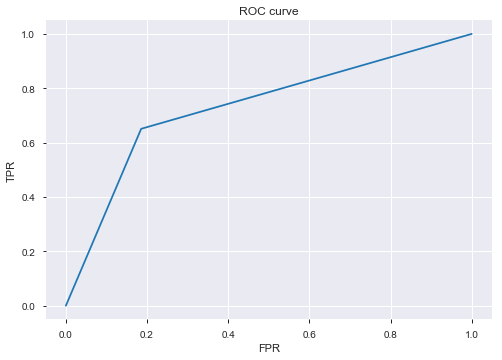

On Test data
ROC_AUC_SCORE is  0.7279367418574193
              precision    recall  f1-score   support

           0       0.99      0.81      0.90     14954
           1       0.05      0.64      0.09       212

    accuracy                           0.81     15166
   macro avg       0.52      0.73      0.49     15166
weighted avg       0.98      0.81      0.88     15166



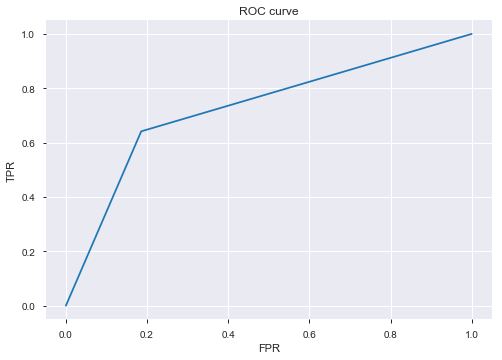

In [232]:
def grid_search_log_reg(dataframe,target):
    X = dataframe
    y = target
    
    
    x_train,x_val,y_train,y_val = train_test_split(X, y, test_size=0.3, random_state=42)

    smote = SMOTE(kind='regular')
    X_sm, y_sm =  smote.fit_sample(x_train, y_train)
    
    
    log_reg = LogisticRegression()
    
    params = {'penalty':['l1','l2'],'C':[0.001,0.01,0.1,1,10,100]}
    grid_search = GridSearchCV(estimator=logreg, param_grid=params,cv=10)
    
    grid_search.fit(X_sm, y_sm)
    y_pred = grid_search.predict(x_val)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_pred)
    print('On Validation Data')
    print('ROC_AUC_SCORE is ',roc_auc_score(y_val, y_pred))
    print(classification_report(y_val, y_pred))
    plt.clf()
    plt.plot(false_positive_rate, true_positive_rate)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()
        
    
    y_pred = grid_search.predict(X_test[['Agency', 'Agency Type', 'Distribution Channel', 'Product Name', 'Duration', 'Net Sales', 'Commision (in value)', 'Age']])
    false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, y_pred)
    print('On Test data')
    print('ROC_AUC_SCORE is ',roc_auc_score(Y_test, y_pred))
    print(classification_report(Y_test, y_pred))
    plt.clf()
    plt.plot(false_positive_rate, true_positive_rate)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()
    
    return grid_search
logreg_feats =['Agency', 'Agency Type', 'Distribution Channel', 'Product Name', 'Duration', 'Net Sales', 'Commision (in value)', 'Age']
logreg_model = grid_search_log_reg(X_train[logreg_feats],Y_train)

In [229]:
df_testdata=pd.read_csv('data/test.csv',sep=',')



In [233]:
df_testdata = df_testdata[logreg_feats]



In [235]:
df_testdata = dummyEncode(df_testdata[logreg_feats])


y_scores_logreg = logreg_model.predict(df_testdata)
y_scores_logreg = np.array(y_scores_logreg)
unique_values,occur_count = np.unique(y_scores_logreg,return_counts=True)
unique_values,occur_count



(array([0, 1], dtype=int64), array([ 2106, 10555], dtype=int64))

In [236]:
# Load the dataframe
df10=pd.read_csv('data/test.csv',sep=',')
df_samplelogreg = pd.DataFrame(df10.iloc[:,0])
df_samplelogreg['Claim']=y_scores.tolist()


In [237]:
df_sample.to_csv('Submissionlogreg.csv') 